In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/home/daniel/OneDrive/Documentos (OneDrive-UNAL)/pro_inv/Proyecto-de-Investigacion/Analisis_Marzo/modelo_poisson':
  os.chdir(r'/home/daniel/OneDrive/Documentos (OneDrive-UNAL)/pro_inv/Proyecto-de-Investigacion/Analisis_Marzo/modelo_poisson')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


/tmp/ipykernel_201047/2739288128.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"/usr/lib/python3.10/importlib/_bootstrap.py": 1678445728.0, "/usr/lib/python3.10/importlib/_bootstrap_external.py": 1678445728.0, "/usr/lib/python3.10/codecs.py": 1678445728.0, "/usr/lib/python3.10/encodings/aliases.py": 1678445728.0, "/usr/lib/python3.10/encodings/__init__.py": 1678445728.0, "/usr/lib/python3.10/encodings/utf_8.py": 1678445728.0, "/usr/lib/python3.10/abc.py": 1678445728.0, "/usr/lib/python3.10/io.py": 1678445728.0, "/usr/lib/python3.10/stat.py": 1678445728.0, "/usr/lib/python3.10/_collections_abc.py": 1678445728.0, "/usr/lib/python3.10/genericpath.py": 1678445728.0, "/usr/lib/python3.10/posixpath.py": 1678445728.0, "/usr/lib/python3.10/os.py": 1678445728.0, "/usr/lib/python3.10/_sitebuiltins.py": 1678445728.0, "/usr/lib/python3.10/types.py": 1678445728.0, "/usr/lib/python3.10/warnings.py": 1678445728.0, "/usr/lib/python3.10/importlib/__init__.py": 1678445728.0, "/usr/lib/python3.10/importlib/_abc.py": 1678445728.0, "/usr/lib/python3.10/keyword.py": 1678445728.0, "/u

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
plt.style.use('ggplot')

In [3]:
ruta = "/home/daniel/OneDrive/Documentos (OneDrive-UNAL)/pro_inv/Proyecto-de-Investigacion/Analisis_Marzo/BD_agrupada.xlsx"

df0 = pd.read_excel(ruta)
df0['ano'] = df0['ano'].astype("category")

In [4]:
# Columnas a cosiderar
v = list()
for i in [0,1,2,3,5,6,7,8,9]:
    v.append(list(df0.columns.values)[i])

# Nueva BD agrupando por nyear
df = df0[v].groupby(['ano', 'sector_ies', 'sexo', 'area_de_conocimiento'], as_index=False)[v[6:9]].agg(np.sum)

In [5]:
df.head(5)

,ano,sector_ies,sexo,area_de_conocimiento,demanda_real,admitidos,demanda_potencial
0,2007,oficial,femenino,agronomia veterinaria afines,6388,2371,706
1,2007,oficial,femenino,bellas artes,6425,1392,399
2,2007,oficial,femenino,ciencias educacion,32780,16150,4832
3,2007,oficial,femenino,ciencias salud,55169,6975,2982
4,2007,oficial,femenino,ciencias sociales humanas,42506,12549,4073


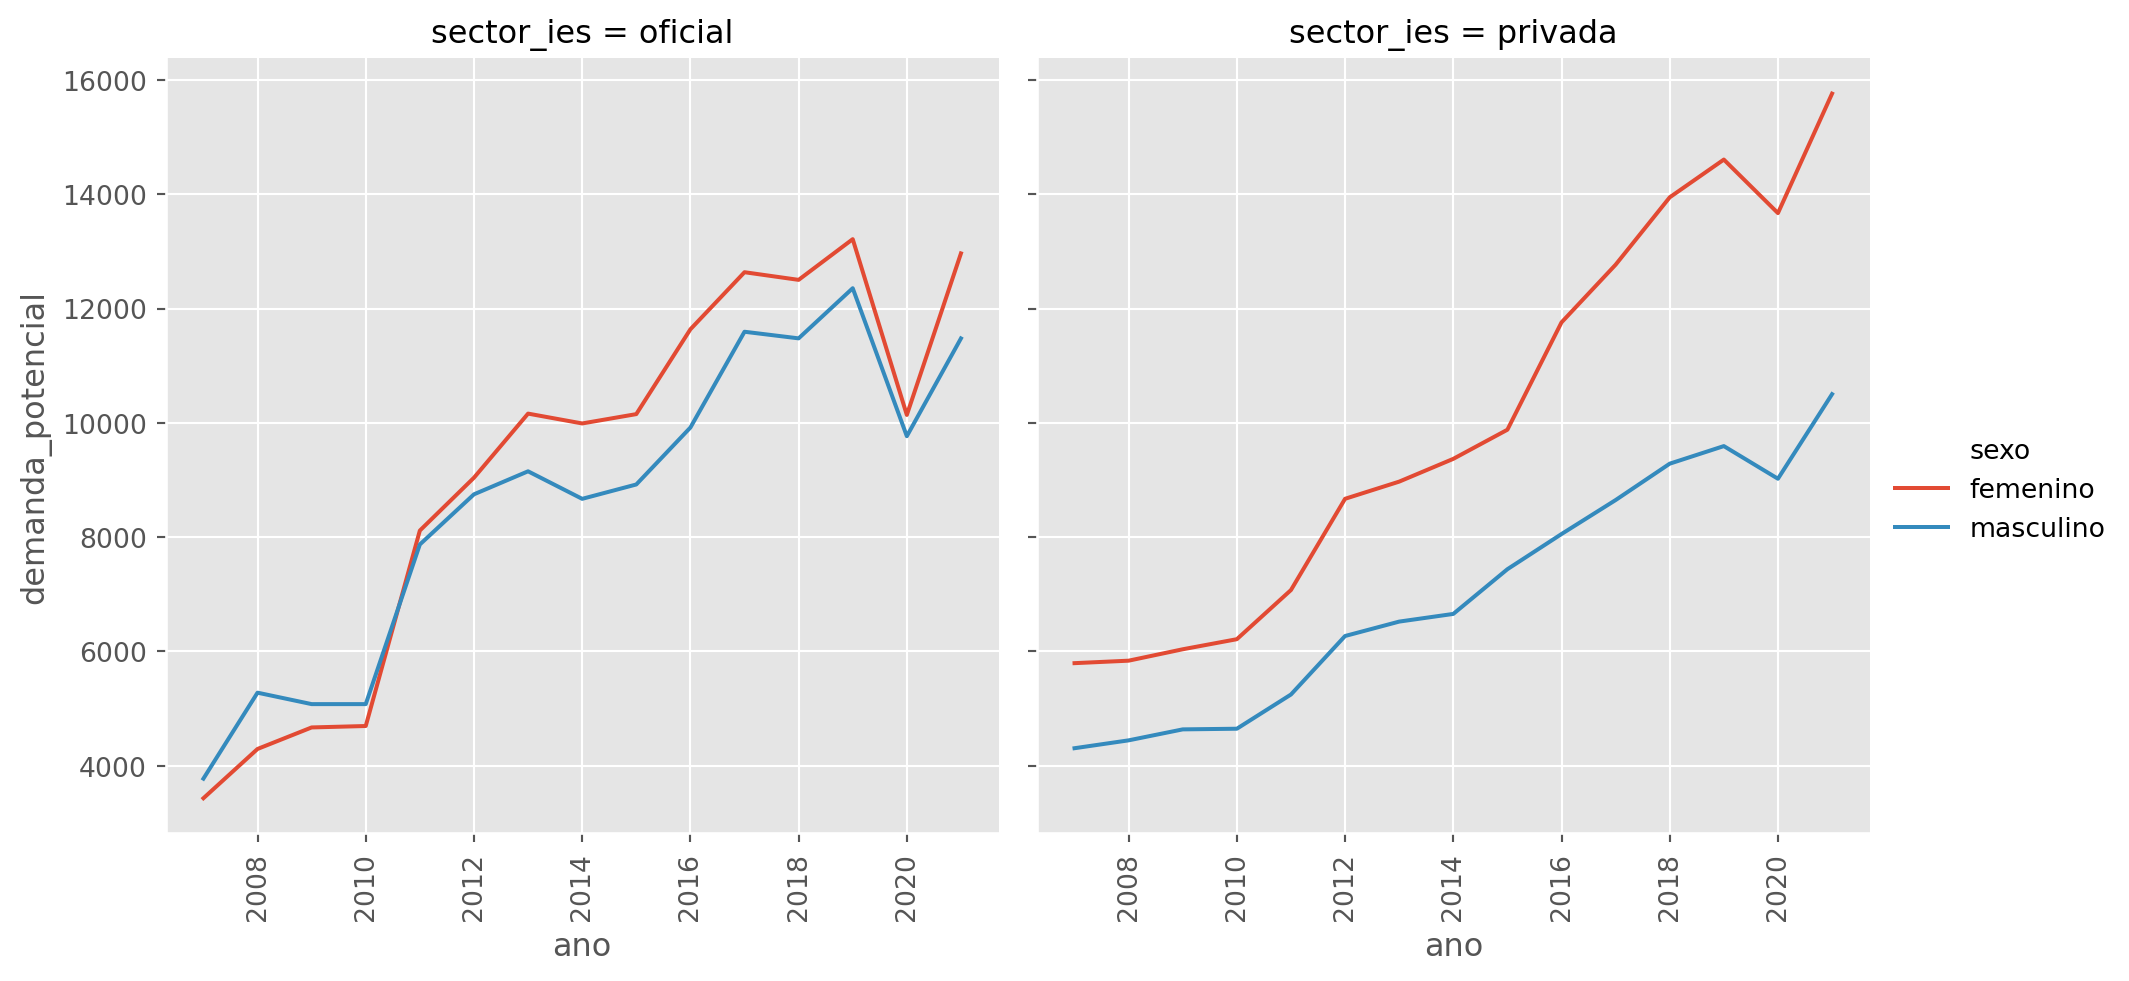

In [6]:
# Serie de tiempo de los datos de Demanda potencial
ax = sns.relplot(kind='line', data=df, x = 'ano', y = 'demanda_potencial', hue='sexo',col='sector_ies', errorbar=None)
ax.tick_params(axis='x', rotation=90)
plt.show()

In [7]:
df_train = df.iloc[0:384,:]
df_test = df.iloc[384:480,:]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=384
Testing data set length=96


In [8]:
expr = "demanda_potencial~ano+sector_ies+sexo+area_de_conocimiento+demanda_real+admitidos"

# One-hot encoding
y_train, X_train = dmatrices(expr, df_train,return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [9]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      demanda_potencial   No. Observations:                  384
Model:                            GLM   Df Residuals:                      361
Model Family:                 Poisson   Df Model:                           22
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1207e+05
Date:                Mon, 03 Apr 2023   Deviance:                   2.2024e+05
Time:                        18:01:56   Pearson chi2:                 2.23e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [10]:
poisson_predictions = poisson_training_results.get_prediction(X_test)

poisson_predictions2 = poisson_training_results.get_prediction(X_train)

#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()

rmse_test = np.sqrt(np.sum((poisson_predictions.predicted_mean-y_test.demanda_potencial.to_numpy())**2)/192)

print("RMSE de test: ",rmse_test)

rmse_train = np.sqrt(np.sum((poisson_predictions2.predicted_mean-y_train.demanda_potencial.to_numpy())**2)/768)

print("RMSE de train: ",rmse_train)

print("Error de Predicción: ",rmse_train-rmse_test)

print(predictions_summary_frame)

RMSE de test:  6542.811493441338
RMSE de train:  1453.3195655737834
Error de Predicción:  -5089.491927867554
             mean    mean_se  mean_ci_lower  mean_ci_upper
384   1287.360892   6.184573    1275.296240    1299.539680
385   2149.542340   8.724712    2132.510056    2166.710660
386   4336.233690  15.004576    4306.924761    4365.742069
387   4160.036441  14.425793    4131.858272    4188.406777
388   7334.880902  23.297815    7289.359866    7380.686211
..            ...        ...            ...            ...
475   3555.573417  12.489072    3531.179351    3580.136002
476   7206.181735  22.797104    7161.638468    7251.002048
477  13463.009286  42.819470   13379.345704   13547.196031
478  15002.050470  56.074701   14892.547672   15112.358426
479    672.141019   3.583117     665.154800     679.200616

[96 rows x 4 columns]


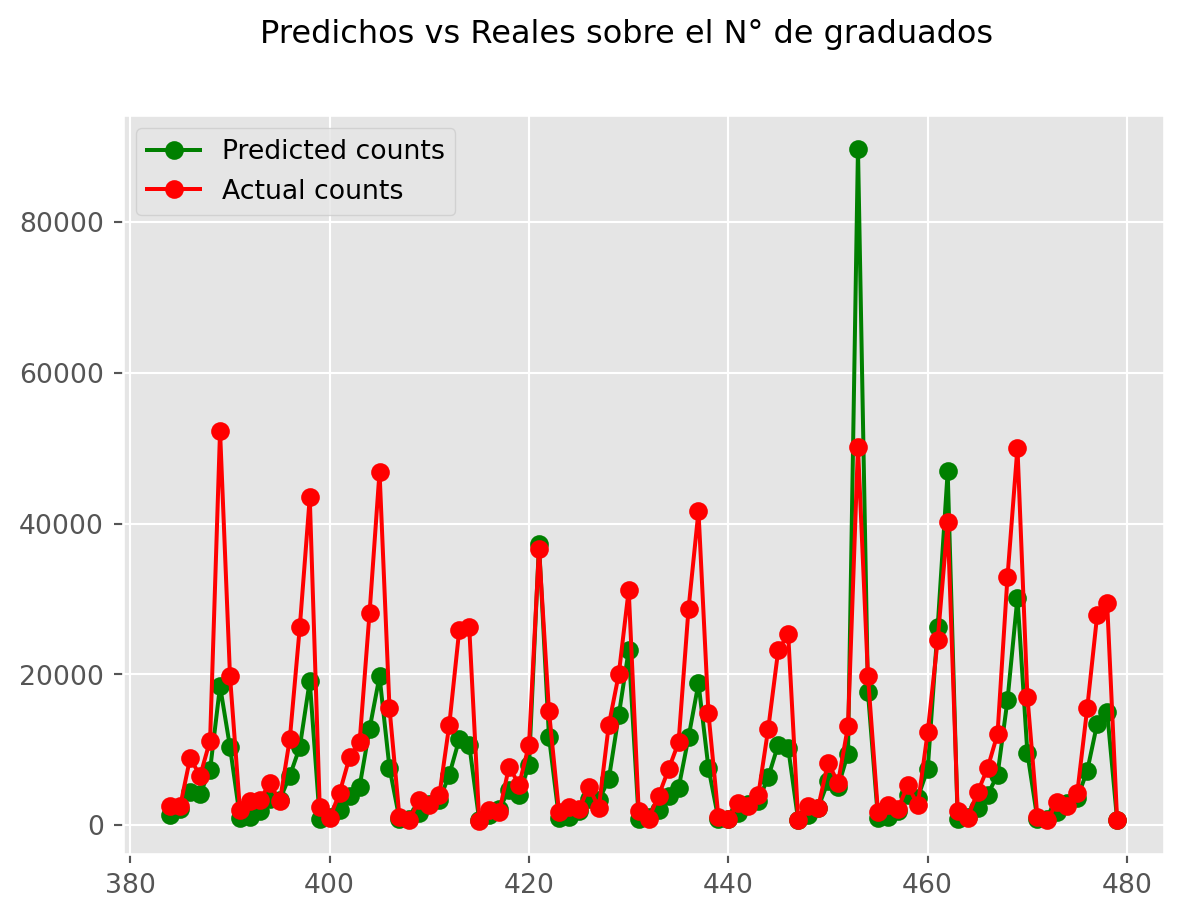

In [11]:
#Mlot the predicted counts versus the actual counts for the test data.
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['demanda_potencial']
fig = plt.figure()
fig.suptitle('Predichos vs Reales sobre el N° de graduados')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

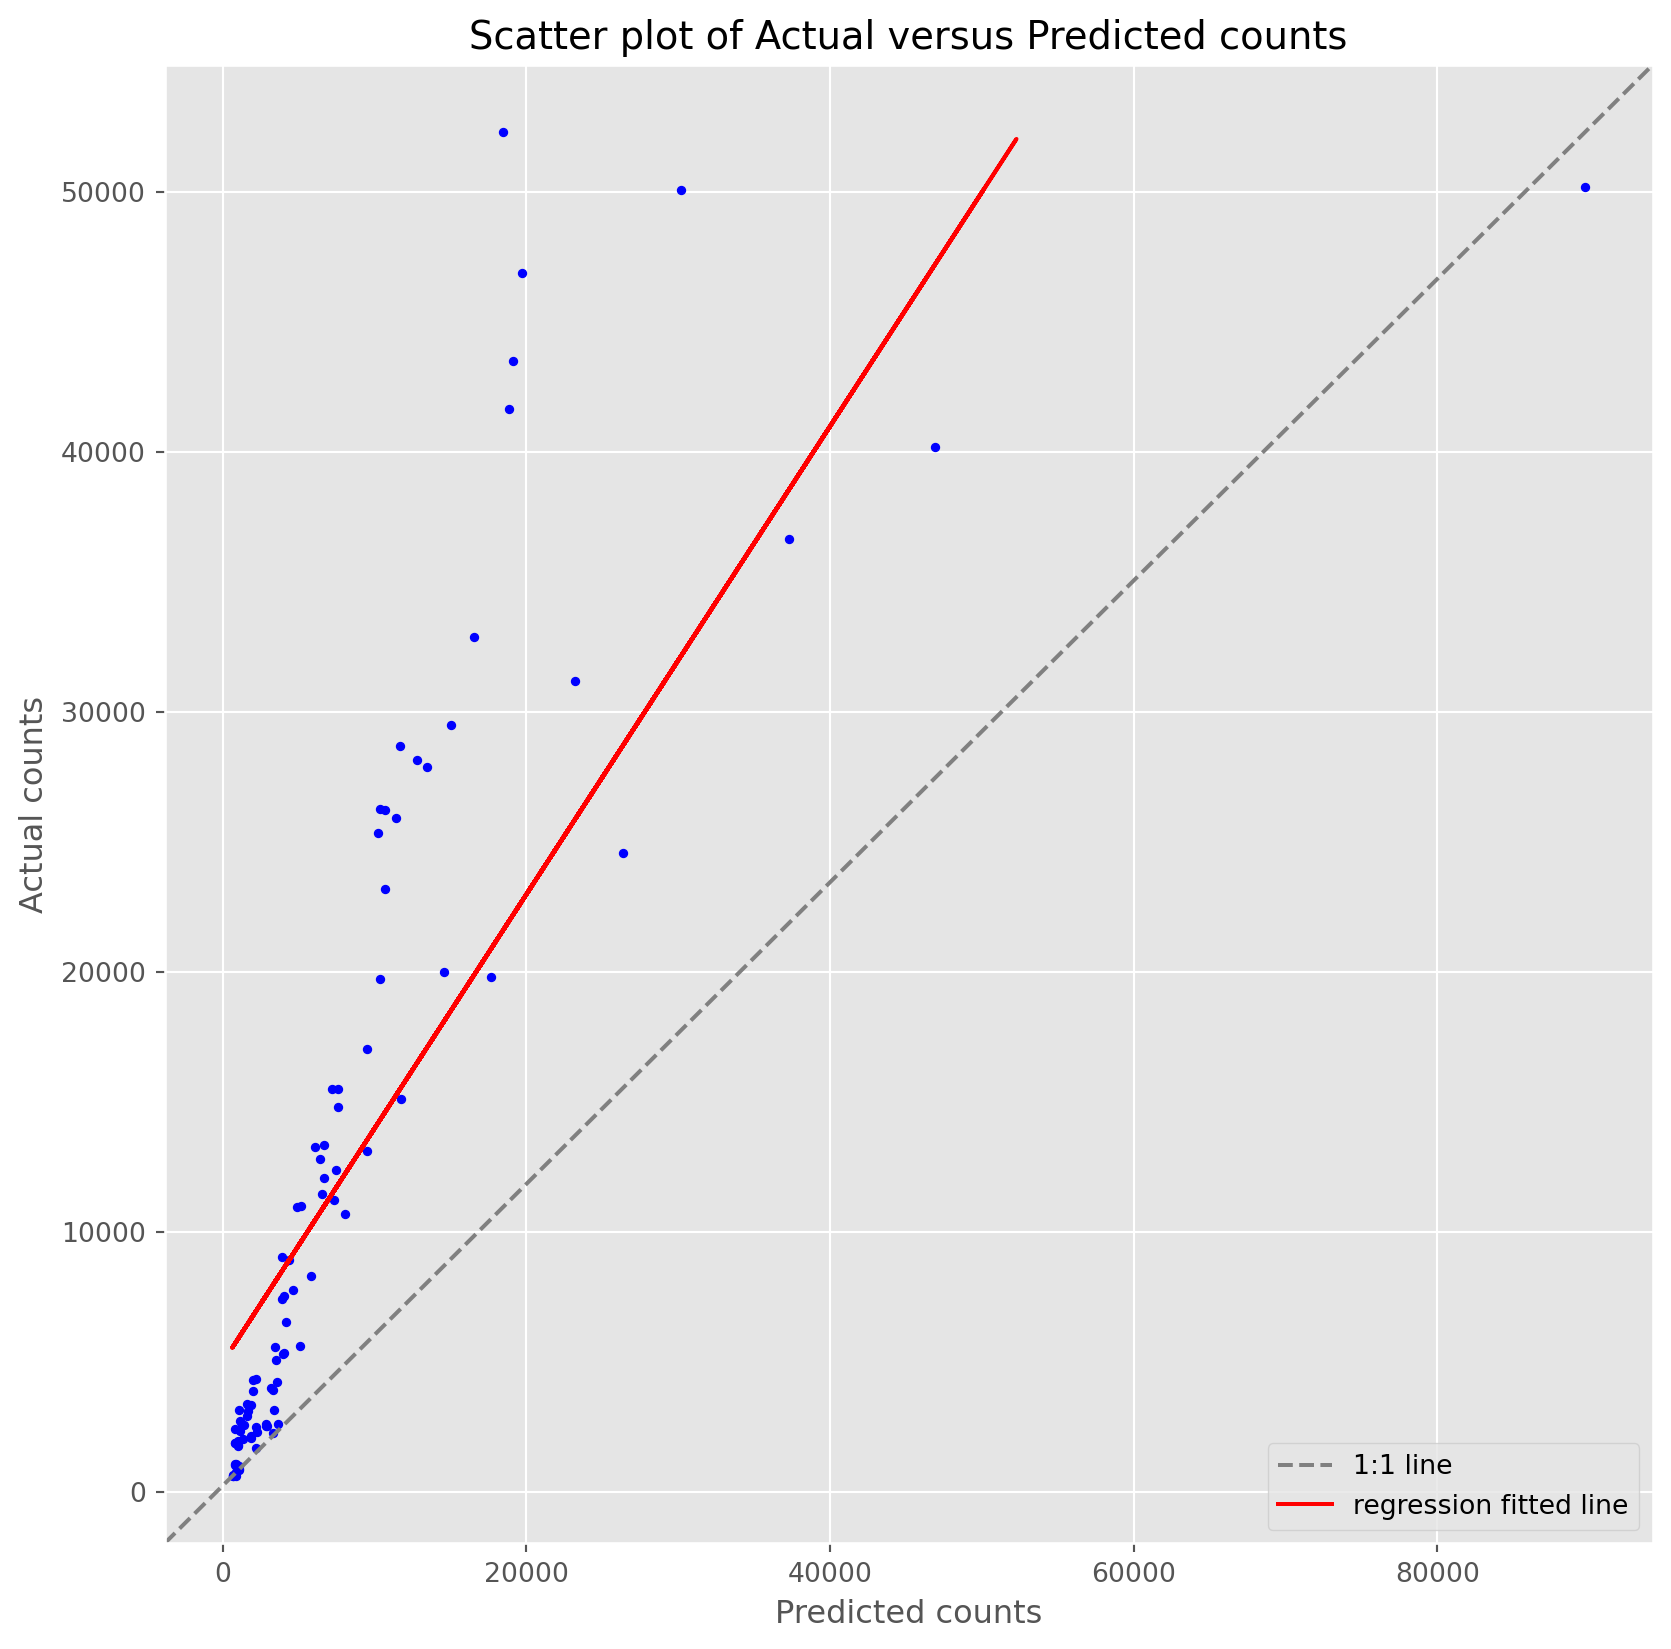

In [12]:
# Linear regression
m, b = np.polyfit(predicted_counts,actual_counts, 1)
#Show scatter plot of Actual versus Predicted counts
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x=predicted_counts, y=actual_counts, marker='.', color = "blue")
ax.plot((0, 1), (0, 1), color = "gray", transform=ax.transAxes, ls = '--', label="1:1 line")
ax.plot(actual_counts, m*actual_counts+b, color = "red", label = "regression fitted line")
ax.set(ylabel ="Actual counts", xlabel = "Predicted counts",
       title="Scatter plot of Actual versus Predicted counts")
plt.legend()
plt.show()